## Creating Anomalies from 500hPa from a List of Cold Air Outbreaks

In [3]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib as mpl
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import time
import warnings

import scipy.stats

warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#Opening 500mb dataset

file = "/scratch/kbarrag/clim680_dataset/mean/erai.z500.day.mean.1979-2019.nc"
ds1 = xr.open_dataset(file)
ds1

<xarray.Dataset>
Dimensions:  (lon: 512, lat: 128, time: 14853)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
Data variables:
    z500     (time, lat, lon) float32 ...

In [5]:
#Selecting the location on the map that we are interested in: North America
ds = ds1.sel(lon=slice(360-180,360-0))
ds

<xarray.Dataset>
Dimensions:  (lon: 256, lat: 128, time: 14853)
Coordinates:
  * lon      (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
Data variables:
    z500     (time, lat, lon) float32 ...

In [6]:
# Have a set of Cold air outbreaks defined from a paper
# "The characteristics of extreme cold events and cold air outbreaks in the eastern United States"(Smith 2015)
# Will do anomalies for the winter months (Dec, Jan, Feb) 500hPa anomalies for each month seperately along with the day of CAO onset
# They use surface air temperature to define what a CAO along with spatial extent. 


In [7]:
#Now selecting the month of january (for now) for every year we have data

months_to_extract = [1] 
ds_j = ds.where(ds['time.month'].isin(months_to_extract), drop=True)
ds_j

<xarray.Dataset>
Dimensions:  (time: 1271, lat: 128, lon: 256)
Coordinates:
  * lon      (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-01-31
Data variables:
    z500     (time, lat, lon) float32 5.743e+04 5.743e+04 ... 4.854e+04

In [8]:
# Create a daily mean a based on the day of the year to create a daily climatology

jan_climo = ds_j.groupby('time.dayofyear').mean()
jan_climo

<xarray.Dataset>
Dimensions:    (dayofyear: 31, lat: 128, lon: 256)
Coordinates:
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31
Data variables:
    z500       (dayofyear, lat, lon) float32 5.742e+04 5.741e+04 ... 4.988e+04

In [9]:
#Now creating the anomalies 

jan_daily_anomaly= ds_j.groupby('time.dayofyear')- jan_climo
jan_daily_anomaly

<xarray.Dataset>
Dimensions:    (lon: 256, lat: 128, time: 1271)
Coordinates:
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-01-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 9 10 ... 23 24 25 26 27 28 29 30 31
Data variables:
    z500       (time, lat, lon) float32 11.98 18.73 ... -1.337e+03 -1.338e+03

In [10]:
#These are the specific dates from Smith 2015 within the month of jan that are relevant to the time period in dataset
#Turning them into datetime format

specific_dates = ['1981-01-07','1982-01-06','1984-01-13','1985-01-29','1988-01-04','1989-01-31','1994-01-12','1996-01-25','2010-01-02']
cao_dates = pd.to_datetime(specific_dates)
cao_dates

DatetimeIndex(['1981-01-07', '1982-01-06', '1984-01-13', '1985-01-29',
               '1988-01-04', '1989-01-31', '1994-01-12', '1996-01-25',
               '2010-01-02'],
              dtype='datetime64[ns]', freq=None)

In [11]:
#using the specific cao dates and selecting them from the anomaly dataset
#These are the onset day. 

cao_dates_jan= jan_daily_anomaly.sel(time=cao_dates)
cao_dates_jan

<xarray.Dataset>
Dimensions:    (lon: 256, lat: 128, time: 9)
Coordinates:
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time       (time) datetime64[ns] 1981-01-07 1982-01-06 ... 2010-01-02
    dayofyear  (time) int64 7 6 13 29 4 31 12 25 2
Data variables:
    z500       (time, lat, lon) float32 -28.13 -26.45 -25.38 ... -638.3 -635.9

Text(0.5, 0.98, '500hPa Geopotential Height for Selected January Cold Air Outbreaks from 1979-2019')

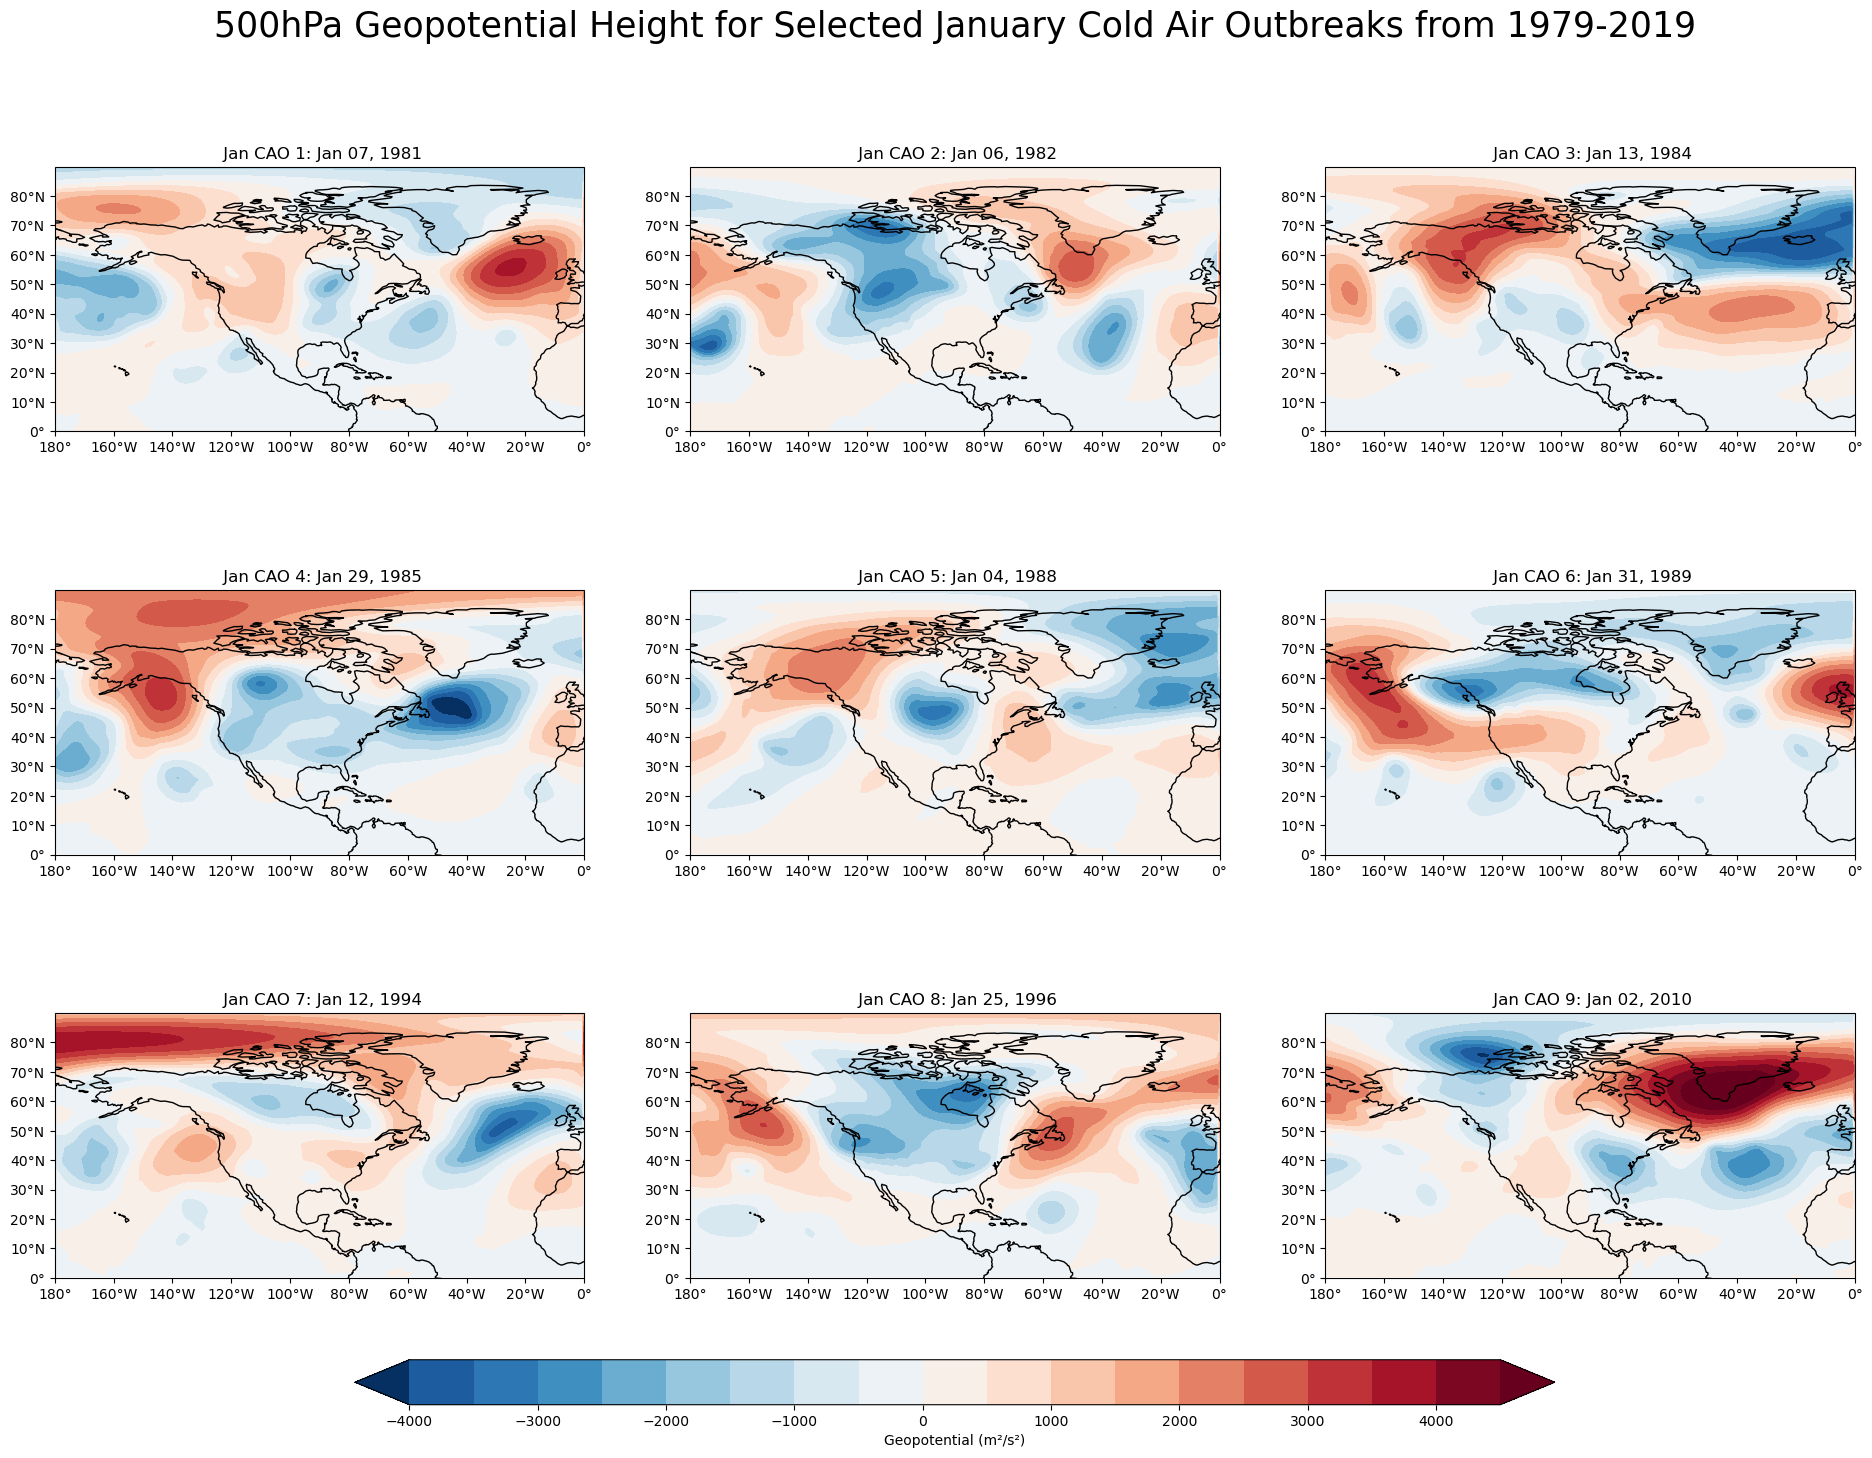

In [12]:
#Now to combine with a 'for' loop to create the anomaly plots
                
# Define the figure and each axis for the 4 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,15))

 
# We will flatten it into a 1-D array
axs=axs.flatten()

min_z500= cao_dates_jan['z500'].min()
max_z500= cao_dates_jan['z500'].max()


clevs = np.arange(-4000,5000,500)

divnorm = colors.CenteredNorm(vcenter=0)

axs=axs.flatten()

#Loop over all of the day and plot
for i, time in enumerate(cao_dates_jan['time']):

    # Select the day
    data=cao_dates_jan['z500'].sel(time=time)

    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=cao_dates_jan['lon'])

    cs1=axs[i].contourf(lons, 
                cao_dates_jan['lat'],data,
                clevs,
                norm=divnorm,
                cmap= "RdBu_r",
                transform = ccrs.PlateCarree(),
                extend='both')
    
 

    # Title each subplot with the name of the model
    formatted_date = time.dt.strftime('%b %d, %Y').values
    axs[i].set_title(f' Jan CAO {i+1}: {formatted_date}', fontsize=12)
    
    #axs[i].set_title(time.values)
    
    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())

    # Draw the coastines for each subplot
    axs[i].coastlines()
    
    axs[i].set_xticks(np.arange(-180,181,20), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    axs[i].set_yticks(np.arange(0,90,10), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter) 

    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())
    
    fig.subplots_adjust( top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.25)

#Colorbar(location, how far to bottom, how long,how tall
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
cbar=fig.colorbar(cs1, cax=cbar_ax,orientation='horizontal',label='Geopotential (m\u00b2/s\u00b2)')



plt.suptitle('500hPa Geopotential Height for Selected January Cold Air Outbreaks from 1979-2019', fontsize=25 )

In [13]:
#Now selecting the month of February for every year we have data

months_to_extract = [2] 
ds_f = ds.where(ds['time.month'].isin(months_to_extract), drop=True)
ds_f

<xarray.Dataset>
Dimensions:  (time: 1158, lat: 128, lon: 256)
Coordinates:
  * lon      (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-02-01 1979-02-02 ... 2019-02-28
Data variables:
    z500     (time, lat, lon) float32 5.741e+04 5.741e+04 ... 5.06e+04 5.059e+04

In [14]:
# Create a daily mean a based on the day of the year to create a daily climatology

feb_climo = ds_f.groupby('time.dayofyear').mean()
feb_climo

<xarray.Dataset>
Dimensions:    (dayofyear: 29, lat: 128, lon: 256)
Coordinates:
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * dayofyear  (dayofyear) int64 32 33 34 35 36 37 38 ... 54 55 56 57 58 59 60
Data variables:
    z500       (dayofyear, lat, lon) float32 5.741e+04 5.741e+04 ... 5.067e+04

In [15]:
#Now creating the anomalies for the month of february by the day

feb_daily_anomaly= ds_f.groupby('time.dayofyear')- feb_climo
feb_daily_anomaly

<xarray.Dataset>
Dimensions:    (lon: 256, lat: 128, time: 1158)
Coordinates:
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time       (time) datetime64[ns] 1979-02-01 1979-02-02 ... 2019-02-28
    dayofyear  (time) int64 32 33 34 35 36 37 38 39 ... 52 53 54 55 56 57 58 59
Data variables:
    z500       (time, lat, lon) float32 -9.027 -6.531 -7.586 ... 737.0 736.0

In [16]:
#These are the specific dates from Smith 2015 within the month of feb that are relevant to the time period in dataset
#Turning them into datetime format

specific_dates2 = ['1979-02-05','1980-02-26','2007-02-01','2015-02-12']
cao_dates2= pd.to_datetime(specific_dates2)

In [17]:
#using the specific cao dates and selecting them from the anomaly dataset

cao_dates_feb= feb_daily_anomaly.sel(time=cao_dates2)
cao_dates_feb

<xarray.Dataset>
Dimensions:    (lon: 256, lat: 128, time: 4)
Coordinates:
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time       (time) datetime64[ns] 1979-02-05 1980-02-26 2007-02-01 2015-02-12
    dayofyear  (time) int64 36 57 32 43
Data variables:
    z500       (time, lat, lon) float32 6.277 1.973 ... -1.143e+03 -1.144e+03

Text(0.5, 0.98, '500hPa Geopotential Height for Selected Febuary Cold Air Outbreaks from 1979-2019')

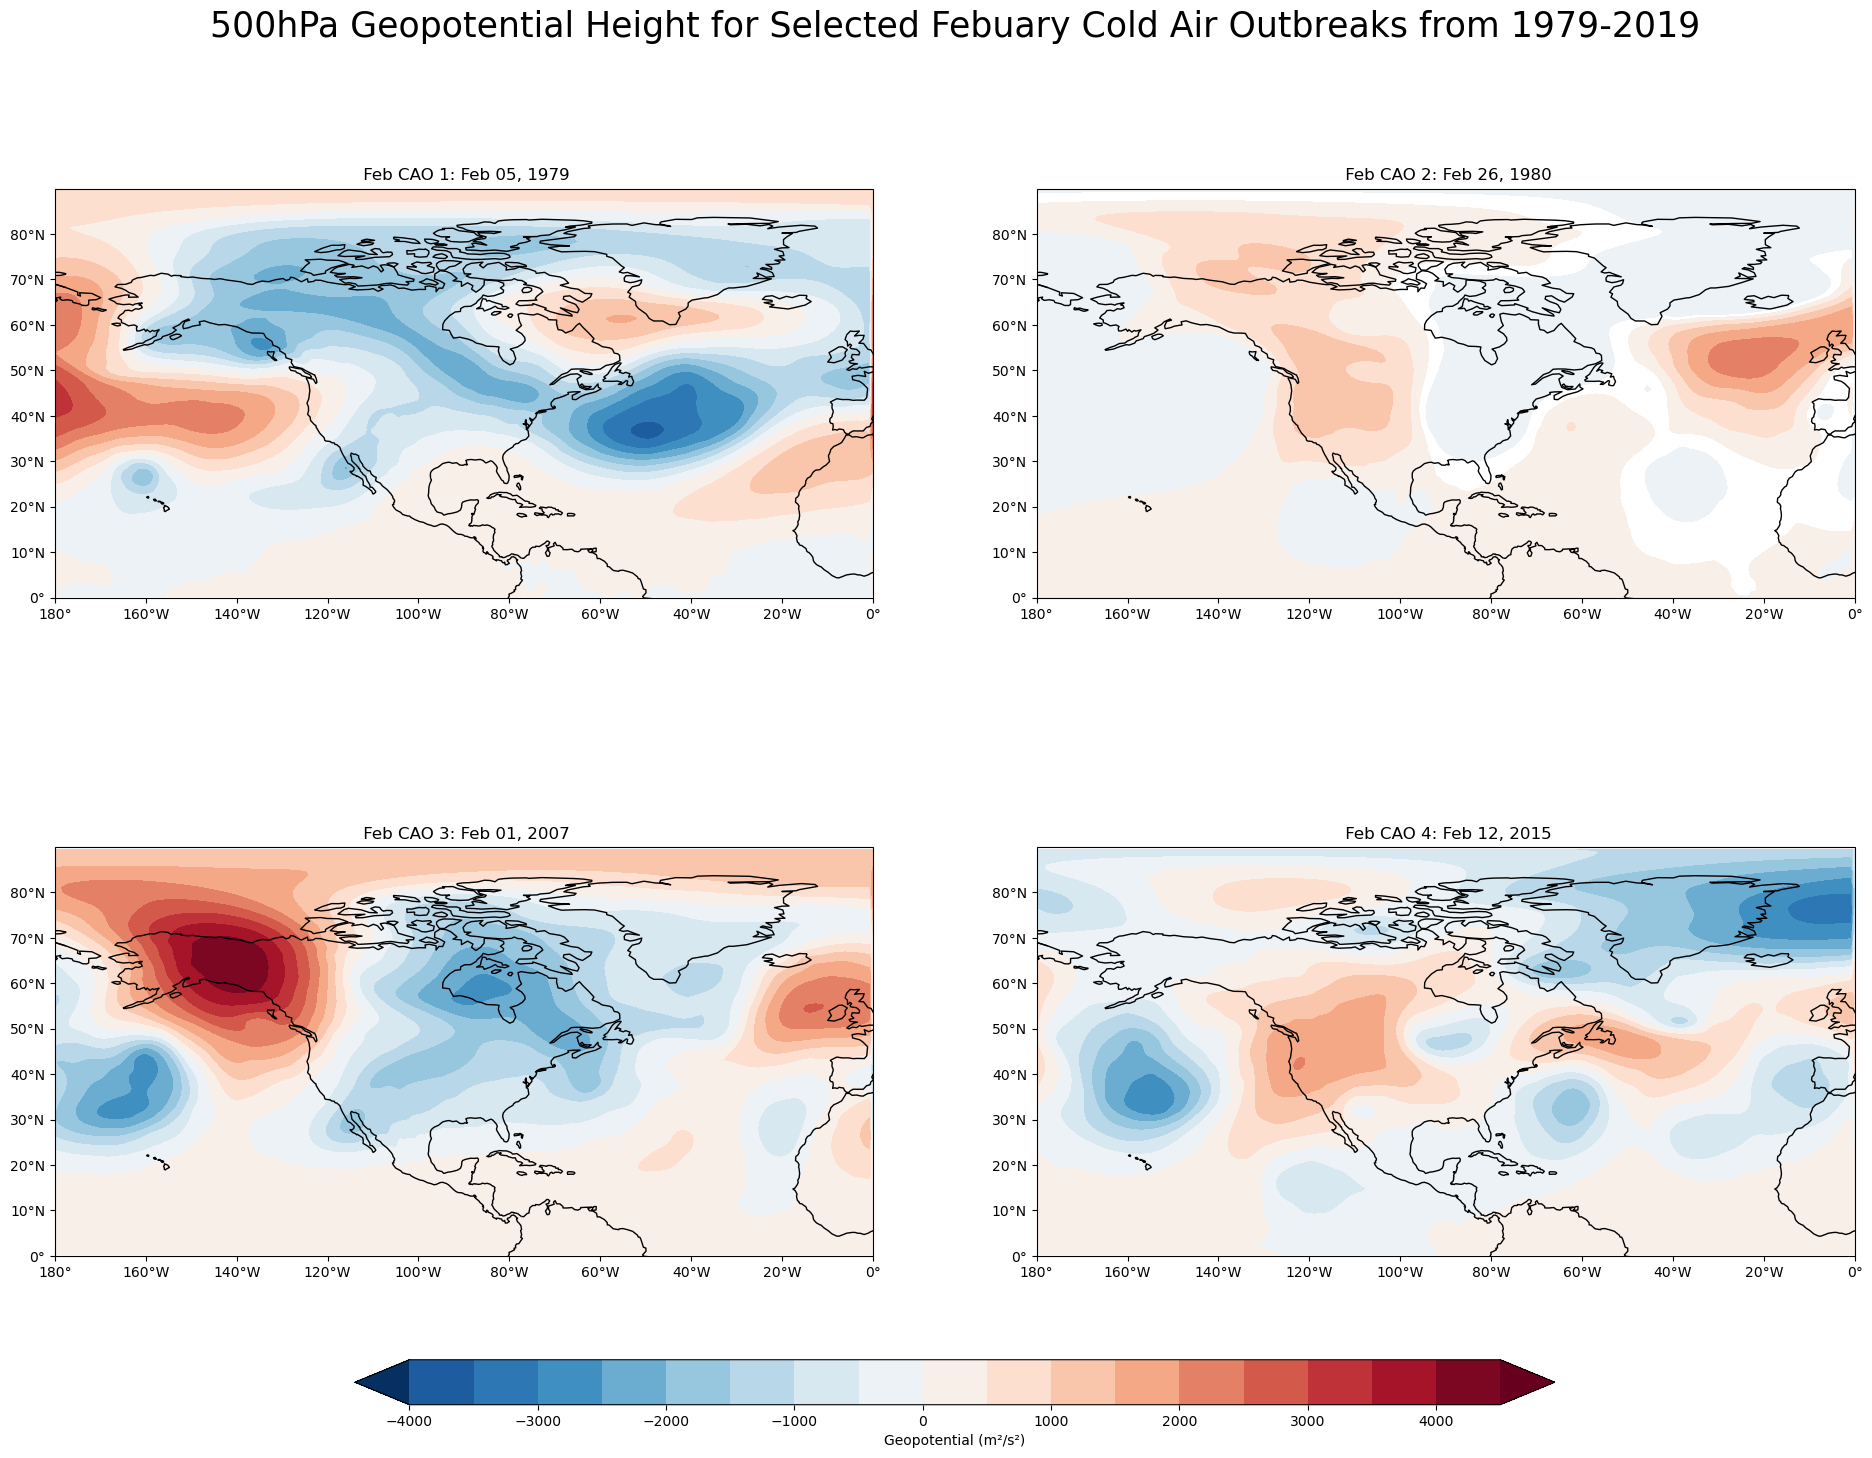

In [18]:
#Creating the plots for the february anomalies

#Now to combine with a 'for' loop to create the plot              
# Define the figure and each axis for the 4 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,15))

 
# We will flatten it into a 1-D array
axs=axs.flatten()

min_z500= cao_dates_feb['z500'].min()
max_z500= cao_dates_feb['z500'].max()


clevs = np.arange(-4000,5000,500)

divnorm = colors.CenteredNorm(vcenter=0)

axs=axs.flatten()

#Loop over all of the day and plot
for i, time in enumerate(cao_dates_feb['time']):

    # Select the day
    data=cao_dates_feb['z500'].sel(time=time)

    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=cao_dates_feb['lon'])

    cs1=axs[i].contourf(lons, 
                cao_dates_feb['lat'],data,
                clevs,
                norm=divnorm,
                cmap= "RdBu_r",
                transform = ccrs.PlateCarree(),
                extend='both')
    
 
    # Title each subplot with the name of the model
    formatted_date = time.dt.strftime('%b %d, %Y').values
    axs[i].set_title(f' Feb CAO {i+1}: {formatted_date}', fontsize=12)
    
    #axs[i].set_title(time.values)
    
    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())

    # Draw the coastines for each subplot
    axs[i].coastlines()
    
    axs[i].set_xticks(np.arange(-180,181,20), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    axs[i].set_yticks(np.arange(0,90,10), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter) 

    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())
    
    fig.subplots_adjust( top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.25)

#Colorbar(location, how far to bottom, how long,how tall
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
cbar=fig.colorbar(cs1, cax=cbar_ax,orientation='horizontal',label='Geopotential (m\u00b2/s\u00b2)')



plt.suptitle('500hPa Geopotential Height for Selected Febuary Cold Air Outbreaks from 1979-2019', fontsize=25 )

In [19]:
#Now selecting the month of december for every year we have data

months_to_extract = [12] 
ds_d = ds.where(ds['time.month'].isin(months_to_extract), drop=True)
ds_d

<xarray.Dataset>
Dimensions:  (time: 1240, lat: 128, lon: 256)
Coordinates:
  * lon      (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time     (time) datetime64[ns] 1979-12-01 1979-12-02 ... 2018-12-31
Data variables:
    z500     (time, lat, lon) float32 5.748e+04 5.747e+04 ... 4.823e+04

In [20]:
# Create a daily mean a based on the day of the year to create a daily climatology

dec_climo = ds_d.groupby('time.dayofyear').mean()
dec_climo

<xarray.Dataset>
Dimensions:    (dayofyear: 32, lat: 128, lon: 256)
Coordinates:
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * dayofyear  (dayofyear) int64 335 336 337 338 339 340 ... 362 363 364 365 366
Data variables:
    z500       (dayofyear, lat, lon) float32 5.744e+04 5.743e+04 ... 5.015e+04

In [21]:
#Now creating the anomalies 

dec_daily_anomaly= ds_d.groupby('time.dayofyear')- dec_climo
dec_daily_anomaly

<xarray.Dataset>
Dimensions:    (lon: 256, lat: 128, time: 1240)
Coordinates:
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time       (time) datetime64[ns] 1979-12-01 1979-12-02 ... 2018-12-31
    dayofyear  (time) int64 335 336 337 338 339 340 ... 360 361 362 363 364 365
Data variables:
    z500       (time, lat, lon) float32 38.02 35.48 ... -1.781e+03 -1.783e+03

In [22]:
#These are the specific dates from Smith 2015 within the month of dec that are relevant to the time period in dataset
#Turning them into datetime format

specific_dates3 = ['1983-12-14','1985-12-13','1989-12-11', '1995-12-07', '2000-12-17','2000-12-29','2005-12-01']
cao_dates3= pd.to_datetime(specific_dates3)

In [23]:
#using the specific cao dates and selecting them from the anomaly dataset

cao_dates_dec= dec_daily_anomaly.sel(time=cao_dates3)
cao_dates_dec

<xarray.Dataset>
Dimensions:    (lon: 256, lat: 128, time: 7)
Coordinates:
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time       (time) datetime64[ns] 1983-12-14 1985-12-13 ... 2005-12-01
    dayofyear  (time) int64 348 347 345 341 352 364 335
Data variables:
    z500       (time, lat, lon) float32 -20.6 -19.14 ... 2.926e+03 2.928e+03

Text(0.5, 0.98, '500hPa Geopotential Height for Selected December Cold Air Outbreaks from 1979-2019')

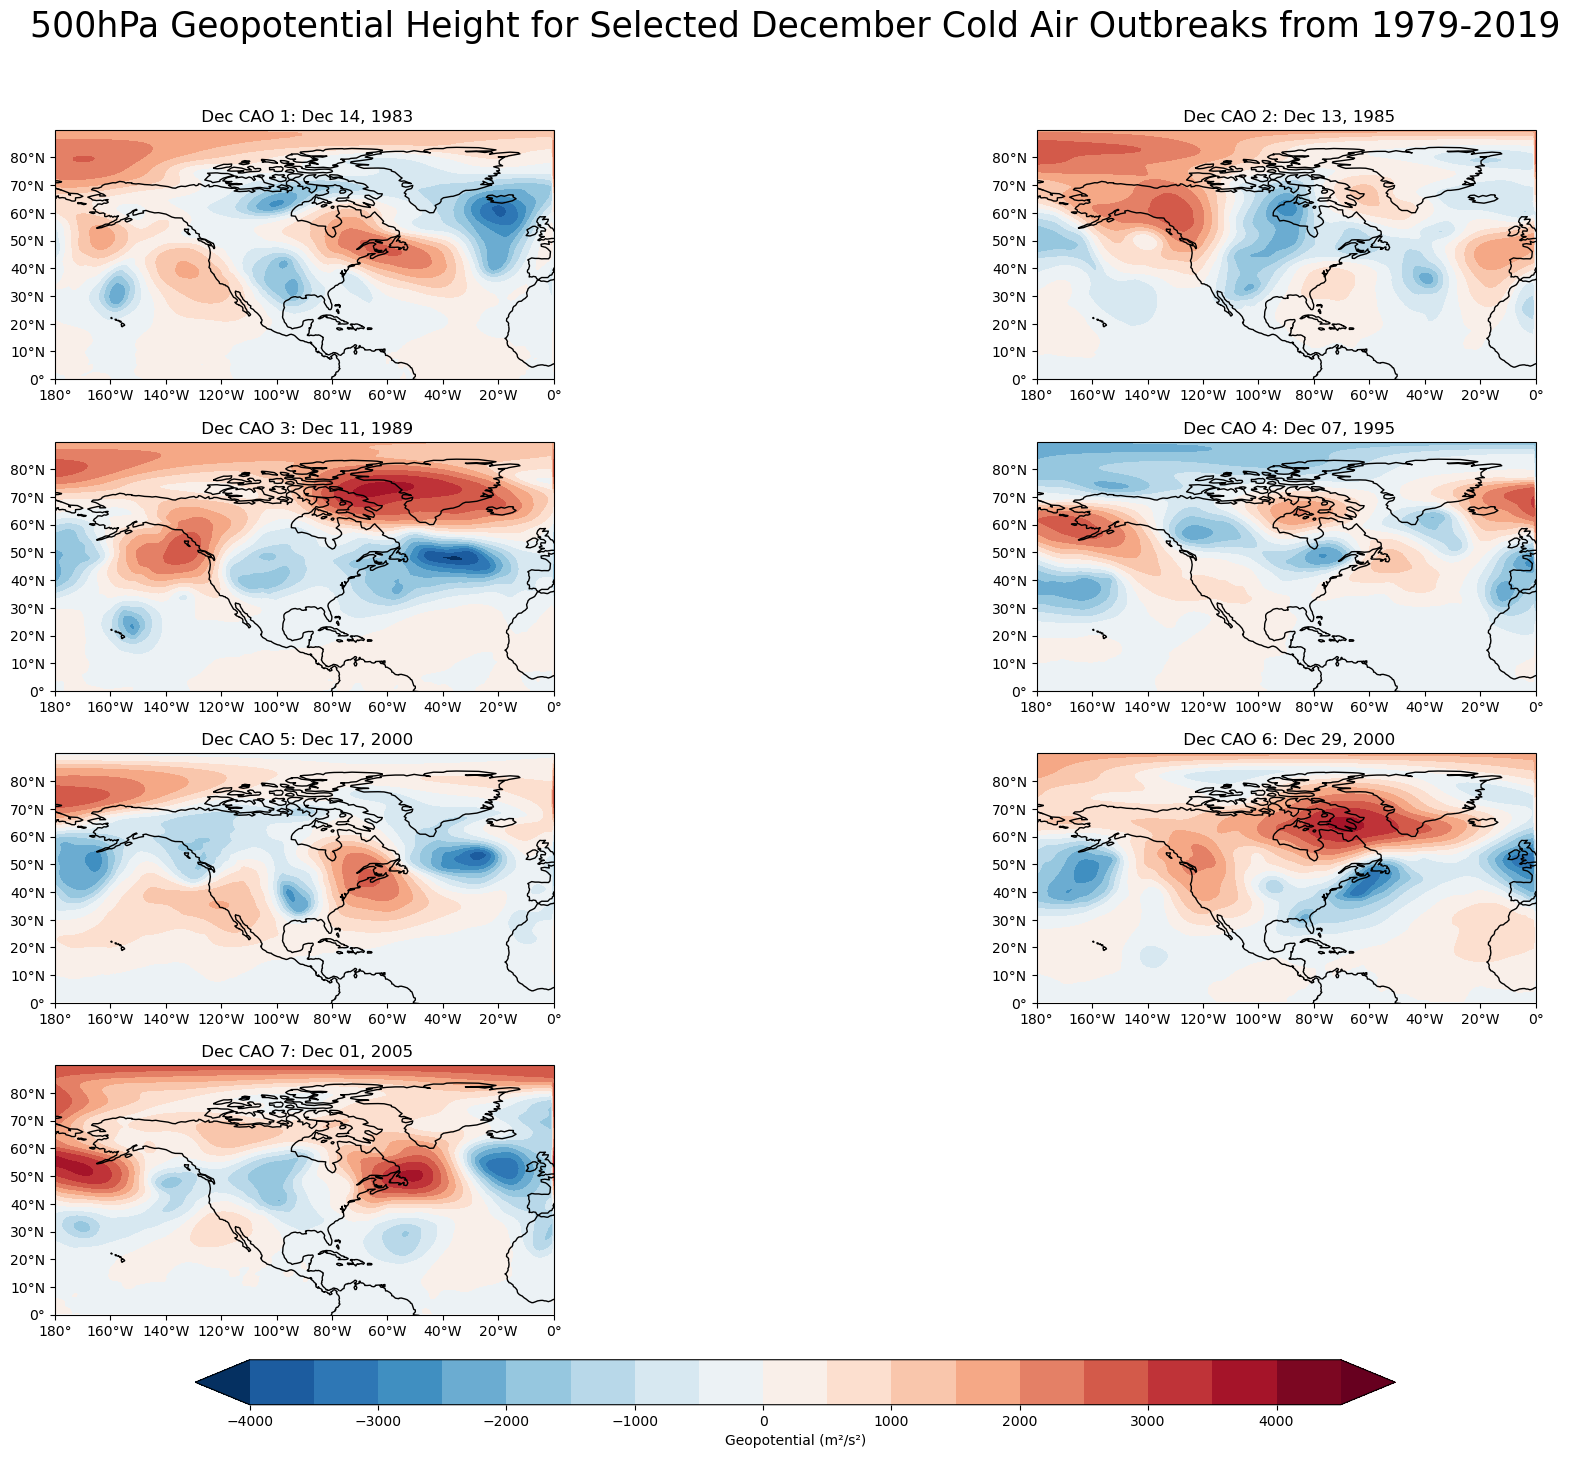

In [24]:
#Creating the dec anomaly plots

#Now to combine with a 'for' loop to create the plot               
# Define the figure and each axis for the 4 rows and 3 columns
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,15))

 
# We will flatten it into a 1-D array
axs=axs.flatten()

min_z500= cao_dates_dec['z500'].min()
max_z500= cao_dates_dec['z500'].max()


clevs = np.arange(-4000,5000,500)

divnorm = colors.CenteredNorm(vcenter=0)

axs=axs.flatten()

#Loop over all of the day and plot
for i, time in enumerate(cao_dates_dec['time']):

    # Select the day
    data=cao_dates_dec['z500'].sel(time=time)

    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=cao_dates_dec['lon'])

    cs1=axs[i].contourf(lons, 
                cao_dates_dec['lat'],data,
                clevs,
                norm=divnorm,
                cmap= "RdBu_r",
                transform = ccrs.PlateCarree(),
                extend='both')
    
 
    # Title each subplot with the name of the model
    formatted_date = time.dt.strftime('%b %d, %Y').values
    axs[i].set_title(f' Dec CAO {i+1}: {formatted_date}', fontsize=12)
    
    #axs[i].set_title(time.values)
    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())

    # Draw the coastines for each subplot
    axs[i].coastlines()
    
    axs[i].set_xticks(np.arange(-180,181,20), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    axs[i].set_yticks(np.arange(0,90,10), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter) 

    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())
    
    fig.subplots_adjust( top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.25)

    
#Deletes the empty plot at the end,since we flatten earlier it makes it a single "list"(not right word) 
#-1 deletes the last one of the list

plt.delaxes(axs[-1])

#Colorbar(location, how far to bottom, how long,how tall
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
cbar=fig.colorbar(cs1, cax=cbar_ax,orientation='horizontal',label='Geopotential (m\u00b2/s\u00b2)')



plt.suptitle('500hPa Geopotential Height for Selected December Cold Air Outbreaks from 1979-2019', fontsize=25 )

In [25]:
#We can stick all the anomalies together/ concatenate on a single dataset and then plot for the all winter months

all_cao_djf= xr.concat([cao_dates_dec, cao_dates_jan, cao_dates_feb], dim='time')
all_cao_djf

<xarray.Dataset>
Dimensions:    (lon: 256, lat: 128, time: 20)
Coordinates:
  * lon        (lon) float64 180.0 180.7 181.4 182.1 ... 357.2 357.9 358.6 359.3
  * lat        (lat) float64 0.351 1.053 1.754 2.456 ... 87.37 88.07 88.77 89.46
  * time       (time) datetime64[ns] 1983-12-14 1985-12-13 ... 2015-02-12
    dayofyear  (time) int64 348 347 345 341 352 364 335 ... 12 25 2 36 57 32 43
Data variables:
    z500       (time, lat, lon) float32 -20.6 -19.14 ... -1.143e+03 -1.144e+03

Text(0.5, 0.98, '500hPa Geopotential Height for Selected Cold Air Outbreaks from 1979-2019')

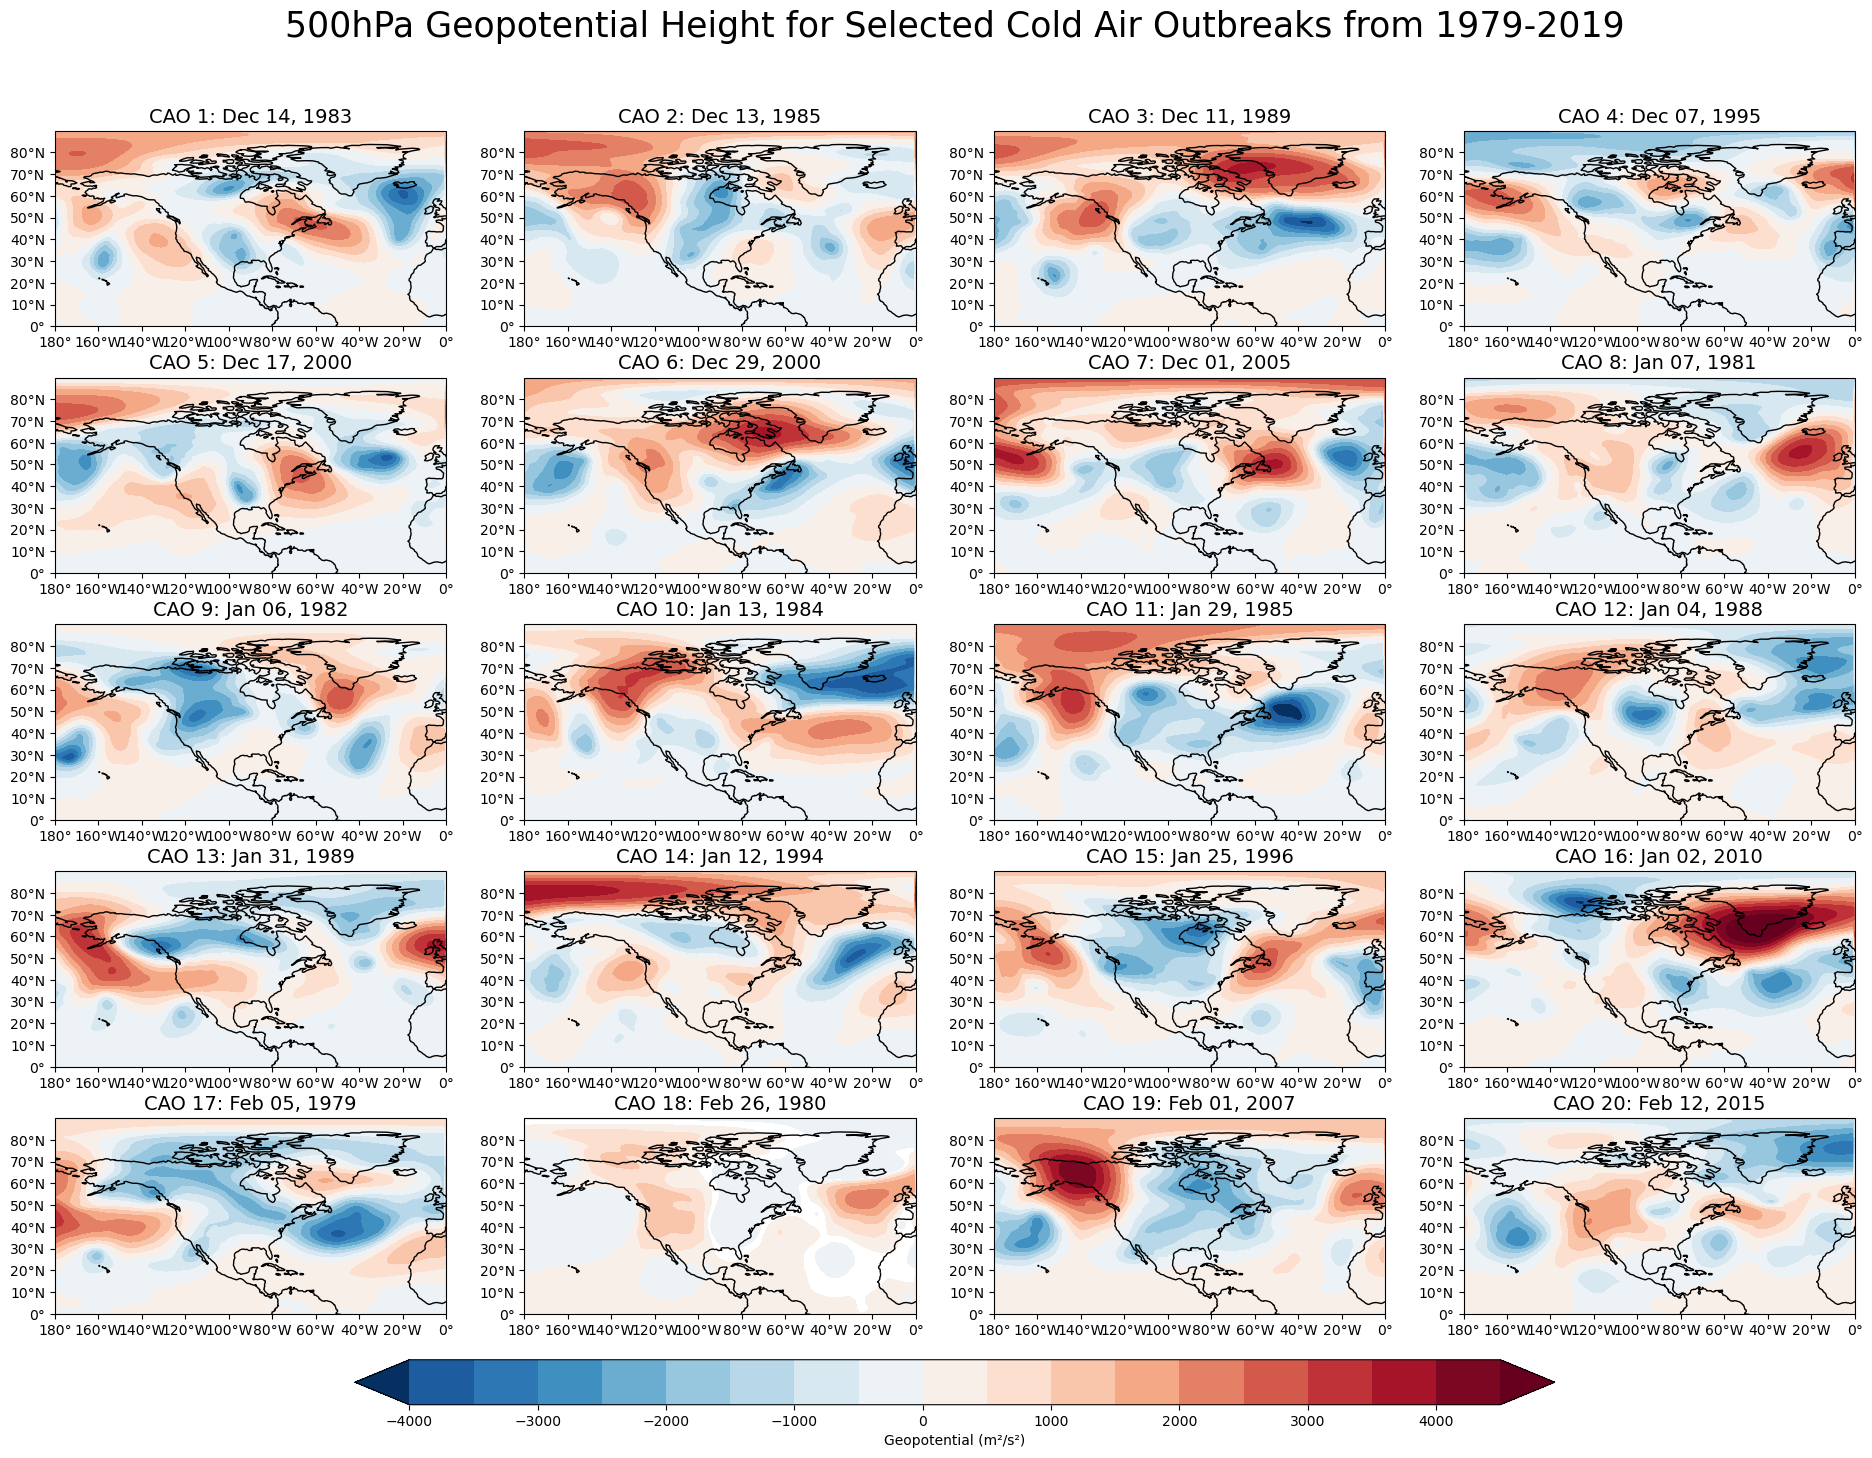

In [26]:
#Plotting all the winter anomalies based on the listed CAO for the winter months of Dec, Jan, Feb

#Now to combine with a 'for' loop to create the plot
                
# Define the figure and each axis for the 4 rows and 3 columns
fig, axs = plt.subplots(nrows=5,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,15))

 
# We will flatten it into a 1-D array
axs=axs.flatten()

min_z500= all_cao_djf['z500'].min()
max_z500= all_cao_djf['z500'].max()


clevs = np.arange(-4000,5000,500)

divnorm = colors.CenteredNorm(vcenter=0)

axs=axs.flatten()

#Loop over all of the day and plot
for i, time in enumerate(all_cao_djf['time']):

    # Select the day
    data=all_cao_djf['z500'].sel(time=time)

    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=all_cao_djf['lon'])

    cs1=axs[i].contourf(lons, 
                all_cao_djf['lat'],data,
                clevs,
                norm=divnorm,
                cmap= "RdBu_r",
                transform = ccrs.PlateCarree(),
                extend='both')
    
    # Title each subplot with the name of the model
    formatted_date = time.dt.strftime('%b %d, %Y').values
    axs[i].set_title(f'CAO {i+1}: {formatted_date}', fontsize=14)
    
    #axs[i].set_title(time.values)
    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())

    # Draw the coastines for each subplot
    axs[i].coastlines()
    
    axs[i].set_xticks(np.arange(-180,181,20), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    axs[i].set_yticks(np.arange(0,90,10), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter) 

    axs[i].set_extent([-180, 0, 90, 0], ccrs.PlateCarree())
    
    fig.subplots_adjust( top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.25)

#Colorbar(location, how far to bottom, how long,how tall
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
cbar=fig.colorbar(cs1, cax=cbar_ax,orientation='horizontal',label='Geopotential (m\u00b2/s\u00b2)')



plt.suptitle('500hPa Geopotential Height for Selected Cold Air Outbreaks from 1979-2019', fontsize=25 )